# YSO_ML - Size-Variable Model

## Logistics

In [1]:
!pip3 install torch torchvision
!pip3 install git+https://github.com/keflavich/imf
!pip3 install git+https://github.com/mkounkel/isochrones
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Cloning https://github.com/keflavich/imf to /tmp/pip-req-build-vb6gd6ge
  Running command git clone -q https://github.com/keflavich/imf /tmp/pip-req-build-vb6gd6ge
  Stored in directory: /tmp/pip-ephem-wheel-cache-q5klmh4x/wheels/24/bf/fc/c41fc4ccc270e25b61d135d0a8f359ef25f1937f65e66e74e1
Successfully built imf
  Cloning https://github.com/mkounkel/isochrones to /tmp/pip-req-build-k1jat5jt
  Running command git clone -q https://github.com/mkounkel/isochrones /tmp/pip-req-build-k1jat5jt
  Stored in directory: /tmp/pip-ephem-wheel-cache-c4qmm0o8/wheels/9c/ad/90/852daea90638ff4fad11d4a1aa80f764f91a0b983d33bff25d
Successfully built isochrones


In [2]:
import pandas as pd

import sys
print(sys.version)
import numpy as np

import torch
from torch import Tensor
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib
print('PyTorch version:', torch.__version__)

import imf,isochrones
from isochrones.parsec import Parsec_Isochrone
from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()
pars = Parsec_Isochrone()
import pickle,time,random
from astropy.io import fits
from astropy.table import Table

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
PyTorch version: 1.1.0


In [0]:
rc = {
    'xtick.direction' : 'in',
    'xtick.major.size' : 4,
    'xtick.major.width' : 0.5,
    'xtick.minor.size' : 2,
    'xtick.minor.width' : 0.5,
    'xtick.minor.visible' :   True,
    'xtick.top' : True,

    # Set y axis
    'ytick.direction' : 'in',
    'ytick.major.size' : 4,
    'ytick.major.width' : 0.5,
    'ytick.minor.size' : 2,
    'ytick.minor.width' : 0.5,
    'ytick.minor.visible' :   True,
    'ytick.right' : True#,
    
#     'font.family' : 'serif'
    }
matplotlib.rcParams.update(rc)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def convunit(v,b,back=False):
  a=[['g',21,0.5],['bp',21,0.5],['rp',18,0.5],['j',17.5,0.5],['h',16.5,0.5],['k',16.5,0.5],
     ['w1',16.5,0.5],['w2',16.5,0.5],['w3',14,0.5],['parallax',20,0.5],['radius',5,0.54],
     ['logl',4,0],['av',20,0.3],['age',4,2],['mass',3,0.5],['teff',0.7,3.4/0.7+0.5],
     ['logg',2,2],['feh',3,-2.5/3+0.5]]
  for i in a:
    if b==i[0]:
      if back:
        return (v+i[2])*i[1]
      else:
        return (v/i[1])-i[2] 

## Define Network

In [0]:
class Net(nn.Module):
    def __init__(self, input_shape = (1, 12), output_shape = 6):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 8, 3, padding = 1)
        self.conv2 = nn.Conv1d(8, 16, 3, padding = 1)
        self.conv3 = nn.Conv1d(16, 32, 3, padding = 1)
        n_size = self._get_conv_output(input_shape)
        print(n_size)
        
        self.fc1 = nn.Linear(n_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, output_shape)      
        
    def _get_conv_output(self, shape):
        bs = 1
        input = (torch.rand(bs, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size
    
    def _forward_features(self, x):
        x = F.max_pool1d(F.relu(self.conv2(F.relu(self.conv1(x)))),2)
        x = F.relu(F.max_pool1d(self.conv3(x), 2))
        return x
    
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
BAD_LOSS = 100000000
# model = Net()

# device = torch.device('cuda')

best_loss = BAD_LOSS
running_dev_loss = 0
badcount = 0
t = time.time()
n=0

a=torch.rand(23500,1,12)
criterion = nn.MSELoss(reduction='sum')
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

In [7]:
device = torch.device('cuda')
model = Net(input_shape = (1,11), output_shape = 6)
model.to(device)

64


Net(
  (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=64, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=6, bias=True)
)

## Prepare Input Data
(Files from other notebooks)

In [0]:
def reduce(fname, remove_x = None, remove_y = None): #Make sure things are put into files in this order!
    xpars =['g','bp','rp','j','h','k','w1','w2','w3','parallax','radius','logl']
    ypars = ['age', 'av', 'mass','teff','logg','feh']
    
    a = np.where(np.isin(xpars, remove_x)==False)[0] #Finds indices that remove input remove_
    b = np.where(np.isin(ypars, remove_y)==False)[0]
    
    X, Y = pickle.load(open(fname, 'rb'))
    X = X[:,:,a]
    Y = Y[:,b]
    X = X.to(device)
    Y = Y.to(device)
    return (X, Y)

# M_clusterx, M_clustery = reduce('drive/My Drive/YSO_ML/trainData/ysotrainf0ms.pickle',
#                                 remove_x = ['w3', 'radius', 'logl'], remove_y = ['av', 'mass', 'teff', 'logg', 'feh'])
# M_clusterx1, M_clustery1 = reduce('drive/My Drive/YSO_ML/trainData/ysotrainf1ms.pickle',
#                                 remove_x = ['w3', 'radius', 'logl'], remove_y = ['av', 'mass', 'teff', 'logg', 'feh'])
# M_clusterx2, M_clustery2 = reduce('drive/My Drive/YSO_ML/trainData/ysotrainf2ms.pickle',
#                                 remove_x = ['w3', 'radius', 'logl'], remove_y = ['av','mass', 'teff', 'logg', 'feh'])


# P_clusterx, P_clustery = reduce('drive/My Drive/YSO_ML/trainData/PCysotrainf0ms.pickle',
#                                 remove_x = ['w3', 'radius', 'logl'], remove_y = ['av','mass', 'teff', 'logg', 'feh'])
# P_clusterx1, P_clustery1 = reduce('drive/My Drive/YSO_ML/trainData/PCysotrainf1ms.pickle',
#                                 remove_x = ['w3', 'radius', 'logl'], remove_y = ['av','mass', 'teff', 'logg', 'feh'])
# P_clusterx2, P_clustery2 = reduce('drive/My Drive/YSO_ML/trainData/PCysotrainf2ms.pickle',
#                                 remove_x = ['w3', 'radius', 'logl'], remove_y = ['av','mass', 'teff', 'logg', 'feh'])

M_clusterx, M_clustery = reduce('drive/My Drive/YSO_ML/trainData/ysotrainf0ms.pickle',
                                remove_x = ['w3'])
M_clusterx1, M_clustery1 = reduce('drive/My Drive/YSO_ML/trainData/ysotrainf1ms.pickle',
                                remove_x = ['w3'])
M_clusterx2, M_clustery2 = reduce('drive/My Drive/YSO_ML/trainData/ysotrainf2ms.pickle',
                                remove_x = ['w3'])


P_clusterx, P_clustery = reduce('drive/My Drive/YSO_ML/trainData/PCysotrainf0ms.pickle',
                                remove_x = ['w3'])
P_clusterx1, P_clustery1 = reduce('drive/My Drive/YSO_ML/trainData/PCysotrainf1ms.pickle',
                                remove_x = ['w3'])
P_clusterx2, P_clustery2 = reduce('drive/My Drive/YSO_ML/trainData/PCysotrainf2ms.pickle',
                                remove_x = ['w3'])

## NN Training

In [0]:
def running(mod, xx, yy, opti, rrange): #Function for typical training passes
    mod.train()
    t = time.time()
    k = random.sample(rrange, len(rrange))
    running_loss = 0
    for i in range(150):
        inputs = xx[k[i*1000:(i+1)*1000]]#Some of these numbers will vary with the sample
        target = yy[k[i*1000:(i+1)*1000]]

        opti.zero_grad()

        # forward + backward + optimize
        outputs = mod(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        opti.step()
        getloss = loss.item()
        running_loss=getloss+running_loss
        return running_loss
            
def devpass(mod, xx, yy, opti): #function for dev passes
        mod.eval()
        opti.zero_grad()
        with torch.no_grad():
            dev_outputs = mod.forward(xx)
            dev_loss = criterion(dev_outputs, yy)
        return(dev_loss.item())
            
def train(mod, x, y, x1, y1):
    n = 0
    optimizer = torch.optim.SGD(mod.parameters(), lr = 1e-5, momentum = .9)
    start_time = time.time()
    mod.train()
    
    ran=range(111000)
    
    for epoch in range(1000):
        runningloss = running(mod, x, y, optimizer, ran)#Forwards and backwards passes for running loss
        n+=1
        if n % 10 == 0:
            devloss = devpass(mod, x1, y1, optimizer)
            print(n, time.time()-t, runningloss/31.25,  devloss)
        if n % 100 == 0:
            torch.save(mod.state_dict(), 'intermediate.pt')
    print('Finished Training')
    print("Total run time in minutes=%.2f" % ((time.time() - start_time) / 60))
    torch.save(mod.state_dict(), 'modelMIST+parsec.pt')

In [0]:
train(model, M_clusterx, M_clustery, M_clusterx1, M_clustery1)
train(model, P_clusterx, P_clustery, P_clusterx1, P_clustery1)
# torch.save(model.state_dict(), 'drive/My Drive/YSO_ML/trainData/save_dicts/reducemodeltrain.pt')

In [0]:
# model = Net(input_shape = (1,11), ouptput_shape = 6)

### Model Testing

In [33]:
model = Net(input_shape = (1,11), output_shape = 6)
model.load_state_dict(torch.load('drive/My Drive/YSO_ML/trainData/save_dicts/reducemodeltrain.pt'))
model.eval()
P = model(P_clusterx2)
M = model(M_clusterx2)
resultP = pd.DataFrame(P.cpu().detach().numpy(), columns = ['age', 'av', 'mass', 'teff', 'logg', 'feh'])
resultM = pd.DataFrame(M.cpu().detach().numpy(), columns = ['age', 'av', 'mass', 'teff', 'logg', 'feh'])
actualP = pd.DataFrame(P_clustery2.cpu().numpy(), columns = ['age', 'av', 'mass', 'teff', 'logg', 'feh'])
actualM = pd.DataFrame(M_clustery2.cpu().numpy(), columns = ['age', 'av', 'mass', 'teff', 'logg', 'feh'])

for obj in [resultP, resultM, actualP, actualM]:
    for label, content in obj.items():
        obj[label] = convunit(content, label, back=True)

def plotModels(label):
    mini = np.nanmin(np.concatenate([actualP[label],resultP[label],actualM[label], resultM[label]]))
    maxi = np.nanmax(np.concatenate([actualP[label],resultP[label],actualM[label], resultM[label]]))
    fig, ax= plt.subplots(1,2, figsize = (16, 8))
    ax[0].plot(actualP[label],resultP[label], '.', markersize = .5)
    ax[0].set_xlim(mini, maxi)
    ax[0].set_ylim(mini, maxi)
    ax[0].plot([mini, maxi],[mini,maxi],'r')
    ax[0].set_title('Parsec ' + label)
    ax[0].set_xlabel('Actual')
    ax[0].set_ylabel('Predicted')
    ax[1].plot(actualM[label],resultM[label], '.', markersize = .5)
    ax[1].set_xlim(mini,maxi)
    ax[1].set_ylim(mini,maxi)
    ax[1].plot([mini,maxi],[mini,maxi],'r')
    ax[1].set_title('MIST ' + label)
    ax[1].set_xlabel('Actual')
    ax[1].set_ylabel('Predicted')
    plt.show()
    
plotModels('age')
plotModels('av')
plotModels('logg')
plotModels('feh')

64


RuntimeError: ignored

## Real Data: final2.fits

### Import fits table, re-sort rows


In [12]:
final2 = fits.open('drive/My Drive/YSO_ML/trainData/fits_files/final2.fits')
trData = Table(final2[1].data)
trData = trData[np.random.permutation(len(trData))].to_pandas()
#Table is sorted by age - that's no good! randomly sample
trData

,SOURCE_ID,LABELS,PROB,RA,DEC,PARALLAX,VLSRRA,VLSRDEC,BP_RP,ABSG,L,L1,B,AGE,AV,PHOT_G_MEAN_FLUX,PHOT_G_MEAN_FLUX_ERROR,PHOT_G_MEAN_MAG,PHOT_BP_MEAN_FLUX,PHOT_BP_MEAN_FLUX_ERROR,PHOT_BP_MEAN_MAG,PHOT_RP_MEAN_FLUX,PHOT_RP_MEAN_FLUX_ERROR,PHOT_RP_MEAN_MAG,PARALLAX_ERROR,VLSRL,VLSRB,SLABEL,RADIAL_VELOCITY,RADIAL_VELOCITY_ERROR,VLSRV,J_M,J_MSIGCOM,H_M,H_MSIGCOM,KS_M,KS_MSIGCOM,W1MPRO,W1MPRO_ERROR,W2MPRO,W2MPRO_ERROR,W3MPRO,W3MPRO_ERROR,W4MPRO,W4MPRO_ERROR,NAME,PLOTNAME,ID,teff_val,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper
0,2184436760646023936,649,0.422149,305.685138,52.856300,1.476715,-3.356305,-2.768989,1.340117,6.423904,88.644799,88.644799,8.917355,8.175590,0.218264,1.107588e+04,9.393503,15.577420,4.640583e+03,20.636667,16.184958,9.264716e+03,35.193031,14.844840,0.032346,-4.177592,1.216476,-1,NaN,NaN,NaN,13.989,0.027,13.482,0.031,13.390,0.051,13.261,0.024,13.378,0.027,13.281,NaN,9.460,NaN,Alessi_Teutsch_11,Alessi_Teutsch_11 (397),397,4921.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.653319,0.637546,0.682943,0.225506,0.213730,0.237282
1,501630293019545856,493,0.928906,69.225265,72.974773,9.121535,-6.745704,4.872813,NaN,NaN,137.697102,137.697102,16.957936,8.643571,0.081619,1.576447e+03,1.859830,17.694168,1.963512e+02,8.700200,19.618805,2.283938e+03,9.909101,16.365210,0.130294,-8.072588,-2.020434,149,NaN,NaN,NaN,14.485,0.035,13.960,0.037,13.645,0.043,13.436,0.026,13.259,0.028,12.744,0.515,9.230,NaN,Platais_3,Platais_3 (787),787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3017193467218614400,1896,0.716115,83.984094,-5.874568,2.549676,1.160824,3.464494,2.440992,7.680455,209.548385,-150.451615,-19.455737,6.894921,0.200000,1.037849e+04,67.006168,15.648030,2.348988e+03,63.803674,16.924187,1.292678e+04,213.943799,14.483194,0.059217,-2.559459,2.607565,5,NaN,NaN,NaN,12.725,0.022,12.037,0.030,11.782,0.023,11.651,0.024,11.537,0.026,10.847,0.394,8.187,NaN,Orion,Orion (13),13,3395.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.166140,0.984068,1.212352,0.162763,0.154572,0.170954
3,5415496367720349952,1919,0.750584,152.166401,-42.618060,1.737733,-6.978619,5.335587,0.880430,4.897170,273.690220,-86.309780,10.825854,7.904081,0.199876,6.258122e+04,47.116181,13.697255,3.285376e+04,89.564165,14.059925,4.295068e+04,127.805121,13.179495,0.017397,-8.782132,0.209216,329,NaN,NaN,NaN,12.573,0.026,12.280,0.026,12.180,0.031,12.179,0.023,12.236,0.023,12.136,0.296,9.149,NaN,,Theia 233,233,5687.666504,0.1180,0.0396,0.2077,0.0460,0.0130,0.1011,0.934505,0.828276,0.996257,0.823370,0.799922,0.846817
4,62713089528550016,876,1.000000,51.037323,23.326640,1.237197,3.017690,-6.251315,0.985917,4.254521,162.718435,162.718435,-27.508028,9.356882,0.636018,5.733442e+04,24.699175,13.792327,2.880010e+04,66.940656,14.202904,4.149285e+04,37.446564,13.216987,0.044570,6.231916,-3.057550,-1,NaN,NaN,NaN,12.542,0.019,12.163,0.019,12.086,0.020,12.023,0.022,12.024,0.023,12.216,0.535,8.887,NaN,,Theia 1501,1501,5334.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.454187,1.435290,1.542395,1.542224,1.417919,1.666528
5,5987017491026151936,1732,1.000000,235.150278,-47.447768,2.490746,-4.623303,-1.511108,NaN,NaN,330.176870,-29.823130,6.276025,7.939870,0.420693,1.361732e+03,1.968889,17.853136,2.853497e+02,11.781528,19.212944,1.971477e+03,12.722883,16.524940,0.143157,-4.609602,1.552399,74,NaN,NaN,NaN,14.739,0.069,14.155,0.076,12.221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,Theia 252,252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6078430514094994304,1410,1.000000,193.343362,-50.898068,1.447758,-5.639492,-0.934211,0.190469,2.177606,303.243875,-56.756125,11.972518,8.159018,0.317823,5.317355e+05,399.448442,11.374126,3.664796e+05,476.243063,11.441263,2.537758e+05,279.541614,11.250794,0.079576,-5.644957,-0.900601,-1,NaN,NaN,NaN,11.097,0.024,11.058,0.023,11.028,0.023,11.020,0.023,11.045,0.021,10.984,0.086,9.075,NaN,,Theia 404,404,8455.000

In [0]:
g = trData['PHOT_G_MEAN_MAG'].astype(np.float32)
x=np.where((g<19) & (np.nan_to_num(g)>0))[0]
g=g[x].to_numpy()
bp = trData['PHOT_BP_MEAN_MAG'][x].astype(np.float32).to_numpy()
rp = trData['PHOT_RP_MEAN_MAG'][x].astype(np.float32).to_numpy()
j = trData['J_M'][x].astype(np.float32).to_numpy()
h = trData['H_M'][x].astype(np.float32).to_numpy()
k = trData['KS_M'][x].astype(np.float32).to_numpy()
w1 = trData['W1MPRO'][x].astype(np.float32).to_numpy()
w2 = trData['W2MPRO'][x].astype(np.float32).to_numpy()
w3 = trData['W3MPRO'][x].astype(np.float32).to_numpy() #ignore for the most part
parallax = trData['PARALLAX'][x].astype(np.float32).to_numpy()
logl = np.log10(trData['lum_val'][x].astype(np.float32).to_numpy())
radius = trData['radius_val'][x].astype(np.float32).to_numpy()

# teff = trData['teff_val'][x].astype(np.float32).to_numpy() #TOO MANY NaN
av = trData['AV'][x].astype(np.float32).to_numpy()
age = trData['AGE'][x].astype(np.float32).to_numpy()

np.warnings.filterwarnings('ignore')
bp[np.where((bp>20.5)|(np.isnan(bp)))[0]]=21
rp[np.where((rp>17.5)|(np.isnan(rp)))[0]]=18
j[np.where((j>17)|(np.isnan(j)))[0]]=17.5
h[np.where((h>16)|(np.isnan(h)))[0]]=16.5
k[np.where((k>16)|(np.isnan(k)))[0]]=16.5
w1[np.where((w1>16)|(np.isnan(w1)))[0]]=16.5
w2[np.where((w2>16)|(np.isnan(w2)))[0]]=16.5
w3[np.where((w3>13.5)|(np.isnan(w3)))[0]]=14
radius[np.where((radius<0.5)|(np.isnan(radius)))[0]]=0.5
logl[np.where((logl<-1.54)|(np.isnan(logl)))[0]]=-1.54

s0 = np.arange(0,int(len(x)*.6))
s1 = np.arange(int(len(x)*.6), int(len(x)*.8))
s2 = np.arange(int(len(x)*.8),len(x)) 

clx0 = Tensor(len(s0), 1, 11)*0-0.5
cly0 = Tensor(len(s0), 3)*0-0.5
clx1 = Tensor(len(s1), 1, 11)*0-0.5
cly1 = Tensor(len(s1), 3)*0-0.5
clx2 = Tensor(len(s2), 1, 11)*0-0.5
cly2 = Tensor(len(s2), 3)*0-0.5

length = [len(s0), len(s1), len(s2)]
sample = [s0, s1, s2]

for i in range(3):
    clx = Tensor(length[i], 1, 11)*0-0.5
    cly = Tensor(length[i], 2)*0-0.5
    c = sample[i]

    clx[:,0,0]= Tensor(convunit(g[c], 'g'))
    clx[:,0,1]= Tensor(convunit(bp[c], 'bp'))
    clx[:,0,2]= Tensor(convunit(rp[c], 'rp'))
    clx[:,0,3]= Tensor(convunit(j[c], 'j'))
    clx[:,0,4]= Tensor(convunit(h[c], 'h'))
    clx[:,0,5]= Tensor(convunit(k[c], 'k'))
    clx[:,0,6]= Tensor(convunit(w1[c], 'w1'))
    clx[:,0,7]= Tensor(convunit(w2[c], 'w2'))
#     clx[:,0,8]= Tensor(convunit(w3[c], 'w3'))
    clx[:,0,8]= Tensor(convunit(parallax[c], 'parallax'))
    clx[:,0,9]= Tensor(convunit(logl[c], 'logl'))
    clx[:,0,10]= Tensor(convunit(radius[c], 'radius'))
    cly[:,0]= Tensor(convunit(age[c], 'age'))
    cly[:,1]= Tensor(convunit(av[c], 'av'))
    pickle.dump([clx, cly], open('drive/My Drive/YSO_ML/trainData/final2_tensors/sample'+str(i)+'.pickle', 'wb'))

In [0]:
#NOW, unpack:
clx0, cly0 = pickle.load(open('drive/My Drive/YSO_ML/trainData/final2_tensors/sample0.pickle', 'rb'))
clx1, cly1 = pickle.load(open('drive/My Drive/YSO_ML/trainData/final2_tensors/sample1.pickle', 'rb'))
clx2, cly2 = pickle.load(open('drive/My Drive/YSO_ML/trainData/final2_tensors/sample2.pickle', 'rb'))

In [29]:
device = torch.device('cuda')
model = Net(input_shape=(1,11),output_shape=2)
model = model.to(device)
clx0 = clx0.to(device)
cly0 = cly0.to(device)
clx1 = clx1.to(device)
cly1 = cly1.to(device)
clx2 = clx2.to(device)
cly2 = cly2.to(device)

64


In [270]:
train(model, clx0, cly0, clx1, cly1)

10 119.66187477111816 0.9227599487304687 1913.665283203125
20 120.78623533248901 1.131769287109375 1820.8897705078125
30 121.85842061042786 1.036957763671875 1829.8853759765625
40 122.95024943351746 0.8157445678710937 1613.4041748046875
50 124.07207918167114 0.8549833984375 1630.186767578125
60 125.1522204875946 0.937668701171875 1617.28759765625
70 126.23707699775696 0.9491840209960938 1610.619873046875
80 127.32332992553711 0.86702197265625 1611.999755859375
90 128.4311385154724 0.9005224609375 1610.723876953125
100 129.5100429058075 0.8457818603515626 1610.3056640625
110 130.59522318840027 0.969720703125 1610.064697265625
120 131.67239022254944 0.9412008666992188 1609.789306640625
130 132.7552604675293 0.8643759155273437 1610.7276611328125
140 133.82557773590088 0.8260384521484375 1609.5299072265625
150 134.94854354858398 0.8843790283203125 1609.4647216796875
160 136.04177618026733 0.8849271240234375 1609.5867919921875
170 137.1220076084137 0.81534326171875 1609.10400390625
180 138.

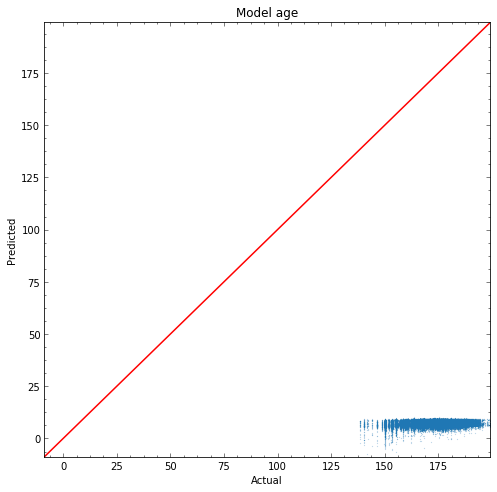

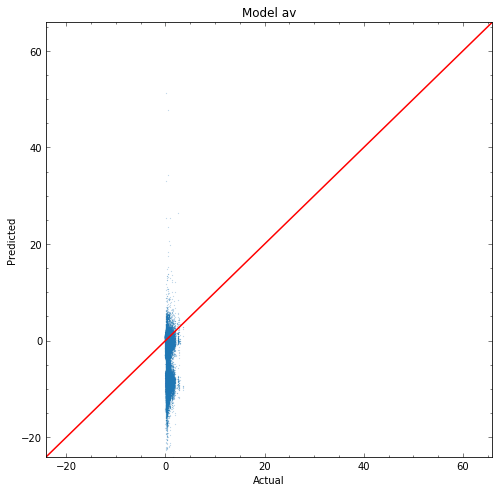

In [23]:
model=model.to(torch.device('cpu'))
model.eval()
d = model(clx2)
dat = pd.DataFrame(d.cpu().detach().numpy(), columns = ['age', 'av', 'mass', 'teff', 'logg', 'feh']) #['age', 'av', 'mass', 'teff', 'logg', 'feh']
obs = pd.DataFrame(cly2.cpu().numpy(), columns = ['age','av'])

for obj in [dat, obs]:
    for label, content in obj.items():
        obj[label] = convunit(content, label, back=True)

def plotFromData(label, actual, result):
    mini = np.nanmin(np.concatenate([actual[label],result[label]]))
    maxi = np.nanmax(np.concatenate([actual[label],result[label]]))
    fig, ax= plt.subplots(1,1, figsize = (8, 8))
    ax.plot(actual[label],result[label], '.', markersize = .2)
    ax.set_xlim(mini, maxi)
    ax.set_ylim(mini, maxi)
    ax.plot([mini, maxi],[mini,maxi],'r')
    ax.set_title('Model ' + label)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    plt.show()
    
plotFromData('age', obs, dat)
plotFromData('av', obs, dat)

In [218]:
print(dat)
print(obs)

            age        av
0      8.201427  0.488673
1      8.191480  0.492661
2      8.230225  0.460935
3      8.236623  0.455227
4      8.242130  0.451748
5      8.235509  0.464828
6      8.236704  0.450986
7      8.203609  0.484982
8      8.202545  0.487893
9      8.230288  0.472214
10     8.205135  0.487085
11     8.207901  0.485323
12     8.239836  0.461199
13     8.240026  0.455398
14     8.261697  0.441161
15     8.234552  0.468241
16     8.261671  0.442756
17     8.241874  0.444095
18     8.236868  0.462188
19     8.212612  0.480653
20     8.185983  0.499550
21     8.204556  0.486462
22     8.198405  0.488198
23     8.231693  0.467743
24     8.230716  0.452159
25     8.214078  0.479797
26     8.233874  0.465874
27     8.220638  0.478695
28     8.229119  0.471546
29     8.230400  0.470105
...         ...       ...
57644  8.185905  0.501909
57645  8.243369  0.442842
57646  8.221609  0.477823
57647  8.243291  0.451209
57648  8.200508  0.488438
57649  8.212999  0.481686
57650  8.226